In [3]:
import pandas as pd

# **Disclaimer: CURATED DATA IS NOT GITIGNORED TO ALLOW EASE OF MARKING**
 #### Running the following code cell will create one more needed dataset in data/curated/ that is over 100MB, and therefore could not be uploaded to the repository.

In [5]:
"""THIS CODE IS FOR THE CURATED DATASET THAT COULD NOT BE UPLOADED TO GITHUB DUE TO SIZE LIMITATION. A COPY OF THE CODE IS AVAILABLE IN ../notebooks/1_preliminary_analysis.ipynb"""
#####################

frauddf = pd.read_csv('../data/raw/consumer_fraud_probability.csv')
consumerdf = pd.read_csv('../data/raw/tbl_consumer.csv', delimiter='|')
userdf = pd.read_parquet('../data/raw/consumer_user_details.parquet')
mergeddf1 = consumerdf.merge(userdf, on='consumer_id', how='left')
mdf = mergeddf1.merge(frauddf, on='user_id', how='left')
df = pd.read_parquet("../test")

#mdf.drop(columns=['order_datetime'], inplace=True)

mdf['fraud_probability'].fillna(0, inplace=True)

import numpy as np
from scipy.stats import zscore

df_cleaned = df[df['dollar_value'] >= 5]

df_cleaned['z_score'] = zscore(df_cleaned['dollar_value'])

threshold = np.sqrt(2 * np.log1p(len(df_cleaned)))

df_cleaned = df_cleaned[df_cleaned['z_score'].abs() <= threshold]

df_cleaned.drop(columns=['z_score'], inplace=True)

df_cleaned.head()

# merge mdf and df on user_id
merged_df = mdf.merge(df, on=['user_id'], how='inner')

merged_df.head()

# export the merged_df to a parquet file
merged_df.to_parquet('../data/curated/consumer_merged.parquet')

C:\Users\xXDra\AppData\Local\Temp\ipykernel_65764\2654570367.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['z_score'] = zscore(df_cleaned['dollar_value'])


# Keeping the API key safe

## Setting the Environment Variable in PowerShell
In PowerShell, I set the environment variable by running:

```powershell
$env:API_KEY="api_key"
```

This stored the API key as an environment variable named `API_KEY`.

---

## Access the Environment Variable in Python
For better security and convenience, I stored the API key in a `.env` file. First, I had to install the `python-dotenv` package:

```bash
pip install python-dotenv
```

Then, I created a `.env` file with the following content:

```
API_KEY=api_key
```

Finally, I loaded the environment variables from the `.env` file using the following Python code:

```python
from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file

api_key = os.getenv('API_KEY')
```

---

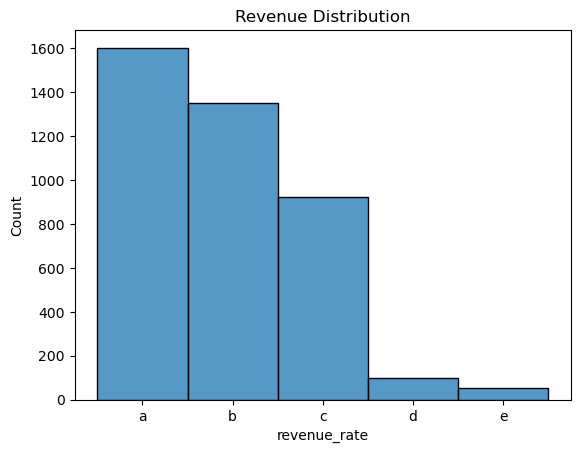

The merchant, consumer, and fraud data was loaded from Parquet and CSV files. Key information regarding merchants were extracted from the tags column, splitting it into category, revenue rate, and take rate components. The merchant's data was merged with fraud probability and missing values were handled by filling fraud_probability with 0, and duplicates were removed. 

The consumer data was cleaned and merged with fraud and user details and dollar_value was cleaned by filtering out low values and removing outliers using z-scores.

Below are the final combined data. 

![output.png](attachment:'../plots/1_Pre-processing and Preliminary Analysis/Distribution of Log Dollar Value.png')

In [11]:
# Pre-processing and Preliminary Analysis of the Data
consumer_data = pd.read_parquet('../data/curated/consumer_merged.parquet')
merchant_info = pd.read_parquet('../data/curated/merchant_info.parquet')

In [12]:
consumer_data.head()

,name,address,state,postcode,gender,consumer_id,user_id,order_datetime,fraud_probability,merchant_abn,dollar_value,order_id
0,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,1,2022-02-20,9.805431,80324045558,19.917432,2c7b1606-d9f1-4eac-99f8-97abc979ab41
1,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,1,2022-02-20,9.805431,62170730910,100.929076,4fe7b08f-72bd-42fb-b2ae-407c3249de55
2,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,1,2022-02-20,9.805431,32709545238,238.927870,9c5555a5-3e2a-48d3-9b5c-4e54efaf0b67
3,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,1,2022-02-20,9.805431,74019238521,5.228331,9138e9c7-3c1a-40da-83dc-8bbe3e14e2cc
4,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,1,2022-02-20,9.805431,67330176930,144.059911,3f958037-236e-430d-ab86-a1e514dc2584


In [13]:
merchant_info.head()

,merchant_abn,name,category,revenue_rate,fraud_probability,take_rate_value
0,10023283211,Felis Limited,"furniture, home furnishings and equipment shop...",e,0.0,0.18
1,10142254217,Arcu Ac Orci Corporation,"cable, satellite, and otHer pay television and...",b,0.0,4.22
2,10165489824,Nunc Sed Company,"jewelry, watch, clock, and silverware shops",b,0.0,4.40
3,10187291046,Ultricies Dignissim Lacus Foundation,"wAtch, clock, and jewelry repair shops",b,0.0,3.29
4,10192359162,Enim Condimentum PC,"music shops - musical instruments, pianos, and...",a,0.0,6.33


## Definitions
Merchant Fraud Probability assesses the risk of a merchant being involved in fraudulent activities. Consumer Fraud Probability estimates the likelihood of customers committing fraud when using the buy now, pay later service.

---
# ABS Features

We retrieved and processed data from the Australian Bureau of Statistics (ABS), specifically examining the **C21_G02_POA** dataflow. This dataflow contains selected medians and averages for Postal Areas (POA) derived from the 2021 Census. 

### NOTE - IF this code wants to be run, an API key should be requested. Outputs however, can be seen in 2_absfeatures2.ipynb.

## 1. Download Swagger YAML

- **Objective**: We started by downloading the Swagger YAML file, which provides a detailed description of the ABS API. This file was essential for understanding how to interact with the API, including available endpoints, request parameters, and response formats.
  
- **Implementation**:
  - A function is called to download the Swagger YAML, which includes error handling to ensure that any issues during the download are caught and reported.
  
- **Output**: The notebook confirms the successful download of the Swagger YAML, indicating that the necessary documentation for API interaction is now available.

```python
import requests

# URL of the ABS Data API Swagger YAML file, provided by the Australian Bureau of Statistics
url = "https://raw.githubusercontent.com/apigovau/api-descriptions/gh-pages/abs/DataAPI.openapi.yaml"

try:
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful

    with open("../data/raw/swagger.yaml", "wb") as file:
        file.write(response.content)
    print("Swagger YAML downloaded successfully!")

except requests.exceptions.HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}")
except Exception as err:
    print(f"An error occurred: {err}")
```

## 2. Retrieve Dataflows

- **Objective**: Then we retrieved dataflows from the ABS API. Dataflows represent collections of statistical data.
  
- **Implementation**:
  - We make an API call to the ABS endpoint to fetch dataflows in XML format.
  - The XML response is parsed to extract relevant information about the dataflows.

- **Output**: The successful retrieval of dataflows is confirmed, and the data is saved to a specified location for later use. Now we can access detailed information about the datasets available in the ABS API.

```python
from dotenv import load_dotenv
import os
import requests

load_dotenv()  # Load environment variables from .env file
api_key = os.getenv('API_KEY')

# API endpoint
url = "https://api.data.abs.gov.au/dataflow/ABS"  # Replace 'ABS' with the agency ID if needed

# API Key (if required)
headers = {
    "x-api-key": api_key, #api_key  
    "Accept": "application/xml"  # Specify that we want XML format
}

# Make the API call
response = requests.get(url, headers=headers)

# Check the response status
if response.status_code == 200:
    xml_data = response.text  # Get the XML response as text
    print("Dataflows retrieved successfully in XML format!")
    with open("../data/raw/dataflows.xml", "w") as file:
        file.write(xml_data)
    print("Dataflows saved successfully to ../temp/dataflows.xml")
else:
    print(f"Failed to retrieve dataflows. Status code: {response.status_code}")
    print(response.text)

```

## 3. Extract Dataflow Information

- **Objective**: Then we extracted specific information about the **C21_G02_POA** dataflow. The 2021 Census data provided the most recent and comprehensive demographic information available. Utilizing datasets from the same time period (2021) reduces discrepancies that can arise when analysing older data alongside newer datasets. **We chose to request by the POA (Postal Area) as the given data only had postcodes as identifying information**.
  
- **Implementation**:
  - We search through the parsed XML data to find the relevant dataflow by its ID, **C21_G02_POA**.
  - Key attributes are extracted, including:
    - **ID**: The identifier for the dataflow.
    - **Agency ID**: The agency responsible for the data (ABS).
    - **Version**: The version of the dataflow, indicating updates or changes.
    - **Is Final**: A flag indicating whether the dataflow is finalized and considered reliable for use.
    - **Name**: A descriptive title of the dataflow.
    - **Description**: A comprehensive description detailing what the dataflow includes and how it should be interpreted.

```python
import xml.etree.ElementTree as ET

# Load and parse the XML file
xml_file_path = '../data/raw/dataflows.xml'
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Adjust the namespace to include the common prefix for data extraction
namespace = {
    'sdmx': 'http://www.sdmx.org/resources/sdmxml/sdmx-2.1',
    'structure': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/structure',
    'common': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common'
}

# Attempt to retrieve C21_G02_POA dataflow details again
dataflow_info_poa = None

# Search through the Dataflows to find C21_G02_POA
for dataflow in root.findall('.//structure:Dataflow', namespace):
    if dataflow.get('id') == 'C21_G02_POA':
        dataflow_info_poa = {
            'id': dataflow.get('id'),
            'agencyID': dataflow.get('agencyID'),
            'version': dataflow.get('version'),
            'isFinal': dataflow.get('isFinal'),
            'name': dataflow.find('common:Name', namespace).text if dataflow.find('common:Name', namespace) is not None else None,
            'description': dataflow.find('common:Description', namespace).text if dataflow.find('common:Description', namespace) is not None else None,
        }
        break

dataflow_info_poa
```

## 4. Retrieving the data, and cleaning

- **Objective**: We then retrieved the data with an API call, and then saved. The CSV originally was in a **very ugly format**. **Since the ABS Data API is still in Beta**, the dataset was not pivoted. Each feature was originally kept in a column called "MEDAVG", and was manually pivoted to match up with the actual name of each feature.

```python
# API base URL
base_url = "https://api.data.abs.gov.au/data"


# Function to make API call to retrieve data in CSV format
def get_data_csv(dataflow_id, data_key, params=None):
    url = f"{base_url}/{dataflow_id}/{data_key}?format=csv"  # Specify CSV format in the URL
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.text  # Return the CSV response as text
    else:
        print(f"Failed to retrieve data for {dataflow_id}. Status code: {response.status_code}")
        return None

# Retrieve all data for C21_G02_POA
dataflow_id = "C21_G02_POA"  # Dataflow ID for C21_G02_POA
data_key = "all"  # Use "all" to retrieve all data

# Get the data
c21_g02_poa_csv_result = get_data_csv(dataflow_id, data_key)

# Save the data to a CSV file
if c21_g02_poa_csv_result:
    with open("../data/raw/C21_G02_POA_data.csv", "w") as f:
        f.write(c21_g02_poa_csv_result)
    print("C21_G02_POA data retrieved and saved successfully to 'C21_G02_POA_data.csv'.")

```

## 5. Dropping columns

- **Objective**: We then removed unneeded columns from the data. Only Median_age_persons, Median_total_household_income_weekly	Median_mortgage_repay_monthly, and Median_rent_weekly was left. Then it was saved in curated data.

---

In [20]:
abs_data = pd.read_csv('../data/curated/2021Census_G02_AUST_POA_curated.csv')
abs_data.head()

,POA_CODE_2021,Median_age_persons,Median_mortgage_repay_monthly,Median_rent_weekly,Median_tot_hhd_inc_weekly
0,2000,32,2800,625,2225
1,2007,30,2500,500,1805
2,2008,28,2600,525,1746
3,2009,37,2800,580,2422
4,2010,36,2900,550,2297


## Limitations
One significant challenge in this project was the mismatch in the date ranges between the primary dataset and the ABS dataset. The primary dataset spanned from April 2021 to October 2022, while the ABS dataset ended in August 2021 which is the most current data available. This discrepancy resulted in incomplete data coverage for the earlier months of the primary dataset (April to July 2021), where no corresponding ABS data was available. 
Moreover, the primary dataset included certain postcodes that are either unused or associated with postboxes, which were not present in the ABS dataset. This mismatch led to missing values during the merging process, potentially affecting the accuracy of eographical or postcode-based analysis.

The merchants' data was categorised based on keywords found in their category descriptions. A list of potential categories was established, including 'Retail Goods', 'Media and Technology', 'Furniture and Home Furnishing', 'Services', and 'Automotives'. Natural Language Processing techniques were applied by normalising the category text and filtering out common stopwords.

In [15]:
merchant_categories = pd.read_parquet('../data/curated/merchant_categories.parquet')
merchant_categories.head()

,merchant_abn,name,category,revenue_rate,fraud_probability,take_rate_value,category_label
0,10023283211,Felis Limited,"furniture, home furnishings and equipment shop...",e,0.0,0.18,Furniture and Home Furnishing
1,10142254217,Arcu Ac Orci Corporation,"cable, satellite, and otHer pay television and...",b,0.0,4.22,"Media and Technology, Services"
2,10165489824,Nunc Sed Company,"jewelry, watch, clock, and silverware shops",b,0.0,4.40,Retail Goods
3,10187291046,Ultricies Dignissim Lacus Foundation,"wAtch, clock, and jewelry repair shops",b,0.0,3.29,"Retail Goods, Services"
4,10192359162,Enim Condimentum PC,"music shops - musical instruments, pianos, and...",a,0.0,6.33,Retail Goods


The transaction data was grouped by each unique combination of merchant abn and datetime, the dollar value and number of transactions were then aggregated to find the total sale value and transaction number of each merchant by date. This was then combined with the merchant category data on merchant abn, to match each merchant with their respective category. The mean of dollar value and number of transactions were taken, grouped by merchant abn. This was then merged with merchant fraud data and null values were replaced with 0 (since we assumed the merchants who were not in the merchant fraud data were not flagged for the potential to be fraud, thus had no chance of fraud). Categories were one hot encoded for each category separated by commas. A model was then trained on this dataset. The model can be used to predict instances with missing revenue.

Gradient Boosting was chosen, as it had the highest R Squared score, a train-split was done on the dataset, and was then used to train and test the model.

In [17]:
merchant_revenue_data = pd.read_parquet('../data/curated/merged_merchant_info_with_categories_and_features.parquet')
merchant_revenue_data.head()

,take_rate_value,fraud_probability,average_monthly_revenue,average_monthly_transactions,Retail Goods,Media and Technology,Furniture and Home Furnishing,Services,Automotives
0,0.18,0.0,216.736529,155.285714,0,0,1,0,0
21,4.22,0.0,37.716001,144.571429,0,1,0,0,0
42,4.40,0.0,11236.094771,0.454545,1,0,0,0,0
53,3.29,0.0,119.526004,16.800000,1,0,0,0,0
73,6.33,0.0,462.329450,19.250000,1,0,0,0,0


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

y = merchant_revenue_data['average_monthly_revenue']

X = merchant_revenue_data.drop(columns=['average_monthly_revenue'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

model = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=300
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

accuracy = model.score(X_test, y_test)
print("Accuracy (R^2 score):", accuracy)

print("Feature Importances:", model.feature_importances_)

Mean Squared Error: 5972074.430302302
Accuracy (R^2 score): 0.43355656146416444
Feature Importances: [0.13298536 0.12425103 0.6537074  0.02590308 0.01044799 0.04256255
 0.00681037 0.00333221]


To predict consumer fraud, transaction data was merged with fraud probability information. First, the transaction and fraud data are combined, creating two classification datasets. In merged_fraud_15, transactions with a fraud probability of 15% or less are classified as non-fraud (0), while in merged_fraud_20, the threshold is set to 20% or less. Logistic regression models are trained on both datasets to classify whether a transaction is fraudulent. Separately, the original merged_fraud dataset, which contains actual fraud probabilities, is used for linear regression to predict fraud probability directly. These models can be used to predict consumer fraud for future consumer data.

In [19]:
merged_fraud_15 = pd.read_parquet('../data/curated/merged_fraud_1.parquet')
merged_fraud_20 = pd.read_parquet('../data/curated/merged_fraud_2.parquet')
merged_fraud = pd.read_parquet('../data/curated/merged_fraud.parquet')

FileNotFoundError: [Errno 2] No such file or directory: '../data/curated/merged_fraud_1.parquet'

In [ ]:
merged_fraud_15.head()

In [ ]:
merged_fraud_20.head()

In [ ]:
merged_fraud.head()

To identify merchants with the highest Compound Weekly Growth Rate (CWGR), the weekly revenue was analysed. After loading and aggregating transaction data by merchant and week, Prophet models were trained for each merchant to forecast future revenue and compute CWGR. Merchants were ranked based on their CWGR, and the top 10 were selected for further analysis. The revenue of these top merchants was scaled using MinMax scaling, and smooth curves were generated to visualise the trends in their monthly revenue over time. This analysis helped identify merchants with the fastest revenue growth, which could signal increased profitability and potential for the BNPL firm. However, it is important to assess whether the growth is sustainable or driven by temporary factors such as seasonal sales (e.g., during Christmas).

# Forecasting with Prophet: Mathematical Foundation and Model Selection

## Why a Piecewise Linear Model Suited Our Case

Using a piecewise linear model in Prophet proved particularly advantageous for our analysis of merchant revenue data due to several key factors:

1. **Capturing Trend Changes**:
   - **Adaptability**: A piecewise linear model allowed for shifts in the trend direction at specified changepoints, making it useful where merchant transaction behaviours changed over time due to market trends or seasonal demand.
   - **Flexible Growth Rates**: The model could accommodate varying growth rates, allowing for a more accurate representation of trends.

2. **Handling Seasonal Patterns**:
   - **Combined Seasonal and Trend Modeling**: Prophet’s ability to model both seasonality and long-term trends was invaluable, effectively capturing fluctuations that occurred at specific times of the year.
   - **Clear Interpretation**: The ability to see where trends changed provided clearer insights into the timing and impact of different business strategies or external events.

## Why Linear Growth Was Chosen Over Logistic Growth

Choosing linear growth over logistic growth in Prophet for forecasting merchant transaction data stemmed from several key factors:

1. **Nature of the Data**:
   - **Current Market Conditions**: Linear growth reflected scenarios where demand was steadily increasing without constraints, as only a short time frame (13 weeks) was projected.

2. **Simplicity and Interpretability**:
   - **Simplicity**: Linear models were easier to implement and interpret, providing a straightforward relationship between time and transaction values.
   - **Clear Forecasting**: We could easily project future values based on past trends.

3. **Flexibility with Changepoints**:
   - **Piecewise Linear Growth**: The model accommodated multiple growth phases through changepoints, capturing significant shifts in growth without the constraints of logistic growth.
   - **Avoiding Overfitting**: Logistic models could overfit the data if capacity was set inaccurately, while linear models avoided this risk.

4. **Data Characteristics**:
   - **Long-Term Trends**: Our historical data showed consistent upward trends without saturation, which aligned well with a linear model.
   - **Early Growth Stages**: In the initial stages of the business or product, growth was often more linear as the market was being penetrated and customer adoption increased.

5. **Less Complexity in Forecasting**:
   - **Reduced Parameter Complexity**: Logistic growth models required additional parameters that needed accurate estimation, whereas linear growth simplified this process.

### Performance and Scalability of Prophet

- **Speed**: Prophet is efficient, allowing it to quickly generate forecasts even with large datasets. This was particularly beneficial as it could process and produce results in a fraction of the time compared to more complex models.

- **Training on Multiple Merchants**: Prophet effectively handled forecasting for a large number of individual merchants, a bit more than 4,000. Each merchant could be modeled independently, making it feasible to scale the forecasting process without a significant increase in computational resources.

- **Scalability**: This model is scalable. It could handle varying amounts of data without significant reconfiguration. If new merchants were added or historical data expanded, our model could adapt to these changes efficiently. Its ability to run independently for each merchant allowed us to maintain performance even as our datasets grew.

## Additive Model Characteristics

1. **Additive Components**: 
   Prophet models time series data as a sum of trend, seasonality, holiday effects, and noise:
   \[
   y(t) = g(t) + s(t) + h(t) + \epsilon_t
   \]
   Each of these components is calculated based on the historical data of the individual time series. This was good in our case as **we could clearly see holiday effects during Christmas**. 

## Our two Prediction Approaches

1. **Individual Predictions for Each Merchant (For generating CWGR)**:
   - When we forecast each merchant's sales individually using Prophet, the model estimates its unique trend and seasonal patterns based on that merchant's historical data. Each merchant can have different seasonal effects, growth rates, and responses to holidays.
   - After making predictions for each merchant, we can sum the predicted values for the desired future time periods.

2. **Aggregating Data Before Prediction (For Visualisation)**: 
   - If we combine the historical transaction data of all merchants into a single time series and then apply Prophet, the model will fit a single trend and seasonal pattern to the aggregated data.
   - This approach assumes that all merchants share similar seasonal patterns and trends, which is the case for the top 100 and bottom 100 merchants for visualisation purposes. And therefore the aggregated model captures common features across all merchants. Due to this aggregation, the line looks largely straight.

# Understanding Compound Weekly Growth Rate (CWGR) in Merchant Revenue Forecasting

## CWGR (feature engineering)

The **Compound Weekly Growth Rate (CWGR)** was used to measure the growth of merchant revenue over time. It quantifies how much revenue is expected to grow week over week. By analysing CWGR, we can assess how effectively a merchant is increasing their revenue, making it the perfect metric for evaluating growth trajectories.

## Calculating CWGR from Predictions

In the context of forecasting, CWGR can be derived from predictions made for the next 13 weeks, typically representing the upcoming quarter. By using a forecasting model like Prophet, we can estimate expected revenue for each week over this time frame. The CWGR was then calculated using the formula:

CWGR = (Final Revenue / Initial Revenue)^(1/n) - 1

Where:
- **Final Revenue** is the predicted revenue at the end of the 13 weeks.
- **Initial Revenue** is the predicted revenue at the beginning of the period.
- **n** is the number of weeks (in this case, 13).

## Advantages

1. **Timely Insights**:
   - The CWGR calculated from a short time frame, such as the next quarter, allowed us to quickly gauge the effectiveness of merchants' different strategies.

2. **Short-Term Forecasting Reliability**:
   - Since it is short time frame, predictions for the next 13 weeks provided a reliable indicator of growth.

## Impact on Final Merchant Ranking

The CWGR emerged as a significant feature in our final merchant ranking. By incorporating CWGR into the ranking criteria, we could prioritise merchants based on their predicted growth potential rather than just their historical performance. This provided a more dynamic view of merchant success and allowed us to recognise those poised for future growth.

```python
# Set order_datetime as the index
df.set_index('order_datetime', inplace=True)

# Aggregate dollar_value for each merchant for each month
weekly_aggregation = df.groupby('merchant_abn').resample('W').sum()

weekly_aggregation.drop(columns=['merchant_abn'], inplace=True)
```

```python
# Initialize a dictionary to store the Prophet models and CWGR for each merchant
merchant_models = {}
merchant_cwgr = {}

# Iterate through each merchant's data in merchant_dfs
for merchant_data in merchant_dfs:
    for merchant_abn, df in merchant_data.items():
        # Prepare the data for Prophet
        df.rename(columns={'order_datetime': 'ds', 'dollar_value': 'y'}, inplace=True)
        
        # Check if the DataFrame has less than or equal to 1 entry
        if len(df) <= 1:
            print(f"Skipping Merchant {merchant_abn} due to insufficient data.")
            merchant_cwgr[merchant_abn] = 0
            continue

        # Initialize and train the Prophet model
        model = Prophet()
        print(f"Training model for Merchant {merchant_abn}...")
        model.fit(df)
        
        # Store the trained model
        merchant_models[merchant_abn] = model
        
        # Make future dataframe for prediction
        future = model.make_future_dataframe(periods=13, freq='W')
        forecast = model.predict(future)
        
        # Calculate CWGR
        initial_value = df['y'].iloc[0]
        final_value = forecast['yhat'].iloc[-1]
        weeks = len(forecast)
        cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
        
        # Store the CWGR
        merchant_cwgr[merchant_abn] = cwgr

merchant_cwgr
```